In [24]:
import quandl
import datetime
import pandas as pd

YEARS = 3
TODAY = datetime.date.today()
START = datetime.date.today()-datetime.timedelta(weeks=52*YEARS)
quandl.ApiConfig.api_key = 'your_key'

In [25]:
btc = {}
btc['btc_price'] = quandl.get('BCHAIN/MKPRU', start_date=START, end_date=TODAY)
btc['btc_ex_vol'] = quandl.get('BCHAIN/TRVOU', start_date=START, end_date=TODAY)
btc['btc_tran_vol'] = quandl.get('BCHAIN/ETRVU', start_date=START, end_date=TODAY)
btc['btc_min_vol'] = quandl.get('BCHAIN/MIREV', start_date=START, end_date=TODAY)
frames = []
col_name = []
for col, df in btc.items():
    print(col)
    col_name.append(col)
    print(df.shape)
    frames.append(df)

btc_price
(1093, 1)
btc_ex_vol
(1093, 1)
btc_tran_vol
(1093, 1)
btc_min_vol
(1093, 1)


In [26]:
frames = pd.concat(frames, axis = 1)
frames.columns = col_name
frames['btc_fut_price'] = frames['btc_price'].shift(-1)
col_name.append('btc_fut_price')

In [27]:
def label_gen(fut, cur):
    if fut > cur:
        return 1
    else:
        return 0
    
frames['label'] = list(map(label_gen, frames['btc_fut_price'], frames['btc_price']))
col_name.append('label')
col_name = col_name[-1:] + col_name[:-1]
frames = frames[col_name]

In [28]:
def add_timestamp(df, col_name, days=4):
    for t in range(1,days):
        reverse = str(-t)
        for col in col_name:
            new_col_name = col + ' :t' + reverse
            frames[new_col_name] = frames[col].shift(t)
            
    return frames
        
col_name.pop(0)
col_name.pop()
frames = add_timestamp(frames, col_name)
frames.drop('btc_fut_price', axis=1, inplace=True)
#frames.ix[:,1:] = frames.ix[:,1:].pct_change()
frames.dropna(inplace=True)
print(frames.head)

<bound method NDFrame.head of             label    btc_price    btc_ex_vol  btc_tran_vol   btc_min_vol  \
Date                                                                       
2014-06-12      0   617.000000  5.290172e+06  9.033728e+07  2.398279e+06   
2014-06-13      0   582.000000  2.099912e+07  1.765106e+08  2.451384e+06   
2014-06-14      1   557.920000  8.696987e+06  3.895745e+07  2.459869e+06   
2014-06-15      1   560.490000  3.812292e+06  3.178060e+07  2.611323e+06   
2014-06-16      1   595.000000  8.714228e+06  4.971113e+07  3.026170e+06   
2014-06-17      1   597.650000  3.078079e+06  4.221560e+07  2.666117e+06   
2014-06-18      0   604.600000  5.370642e+06  5.136150e+07  2.576805e+06   
2014-06-19      0   604.320000  1.828068e+06  4.807415e+07  2.288560e+06   
2014-06-20      0   593.330000  4.531653e+06  4.111779e+07  2.750678e+06   
2014-06-21      1   590.990000  2.181394e+06  3.411228e+07  2.797747e+06   
2014-06-22      0   596.080000  2.470476e+06  2.977325e+07

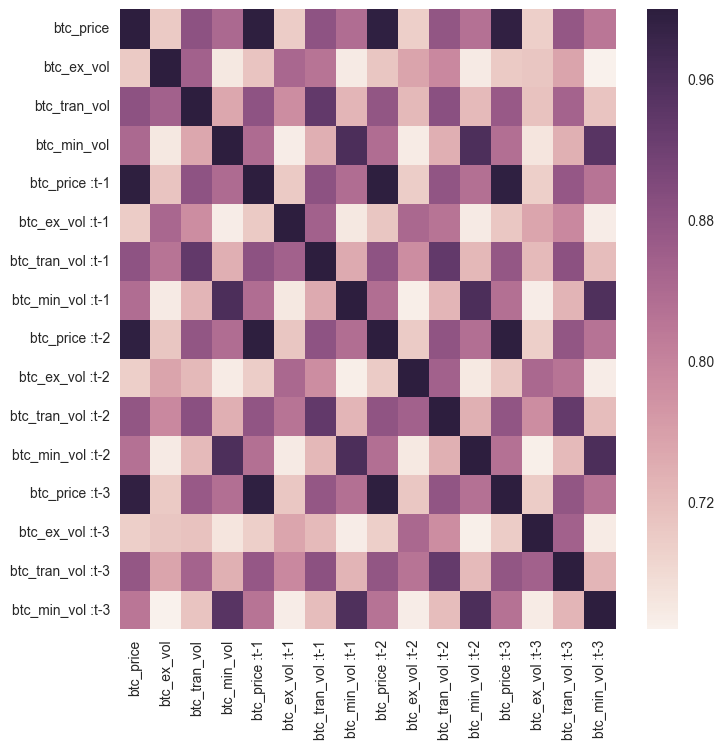

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
feature = frames.ix[:,1:]
sns.heatmap(feature.corr())
plt.show()

In [31]:
import sklearn
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
import numpy as np

RS = 20170605
#df = frames[-360:].sort_values('label')
df = frames[-360:]
df_feature = np.array(df.ix[:,1:])
df_feature = scale(df_feature)
df_label = np.array(df.ix[:,0])
y = np.zeros(360)
y[:180] = 1
two_d_feat = TSNE(perplexity=100, learning_rate=200, 
                  random_state=RS,n_iter=2000).fit_transform(df_feature)

def scatter(x, y):
    palette = np.array(sns.color_palette('hls', 2))
    f = plt.figure(figsize=(8,8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=5, 
                    c=palette[y.astype(np.int)])
    #sc = ax.scatter(x[:,0], x[:,1], lw=0, s=5)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    #ax.axis('off')
    ax.axis('tight')
    
    return f, ax , sc

scatter(two_d_feat, y)
plt.savefig('tsne-generated.png', dpi=400)

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
